# **Import Libraires**

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time

In [2]:
import torch
import torchvision
from torch import optim
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import multiprocess
import psutil

# **Data Preprocessing**

## **Building Up the Dataset**

(512, 640, 3) (512, 640, 3)


(-0.5, 639.5, 511.5, -0.5)

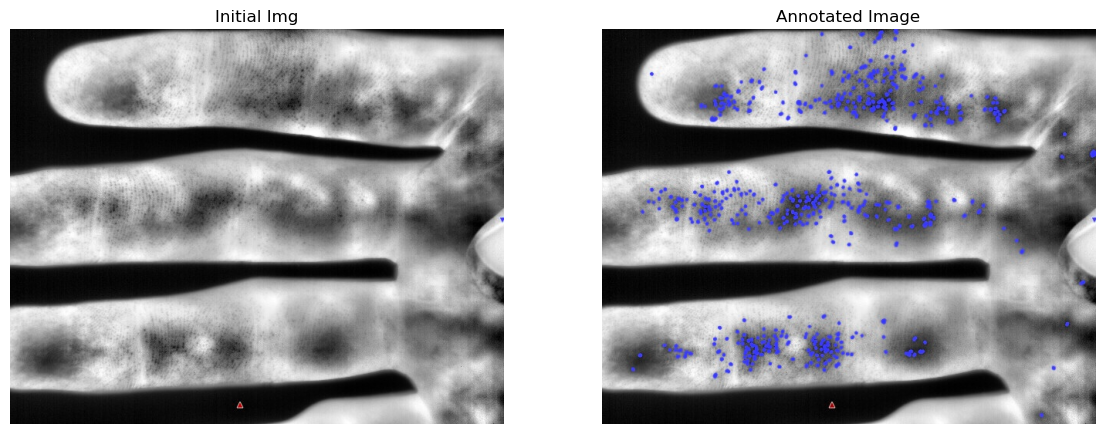

In [14]:
# Import data 
image_path = '/Users/rickysu/Projects/sweatPoresActivation/input_images/raw/8.bmp'
img = cv2.imread(image_path)

annotated_img_path = '/Users/rickysu/Projects/sweatPoresActivation/input_images/annoted/8.bmp'
annotated_img = cv2.imread(annotated_img_path)

print(img.shape, annotated_img.shape) # make sure two images are in the same shape

# show the image 
plt.figure(figsize = (14, 8))

plt.subplot(1,2,1)
plt.imshow(img, cmap = 'gray')
plt.title("Initial Img")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(annotated_img, cmap = 'gray')
plt.title("Annotated Image")
plt.axis("off")

9 12


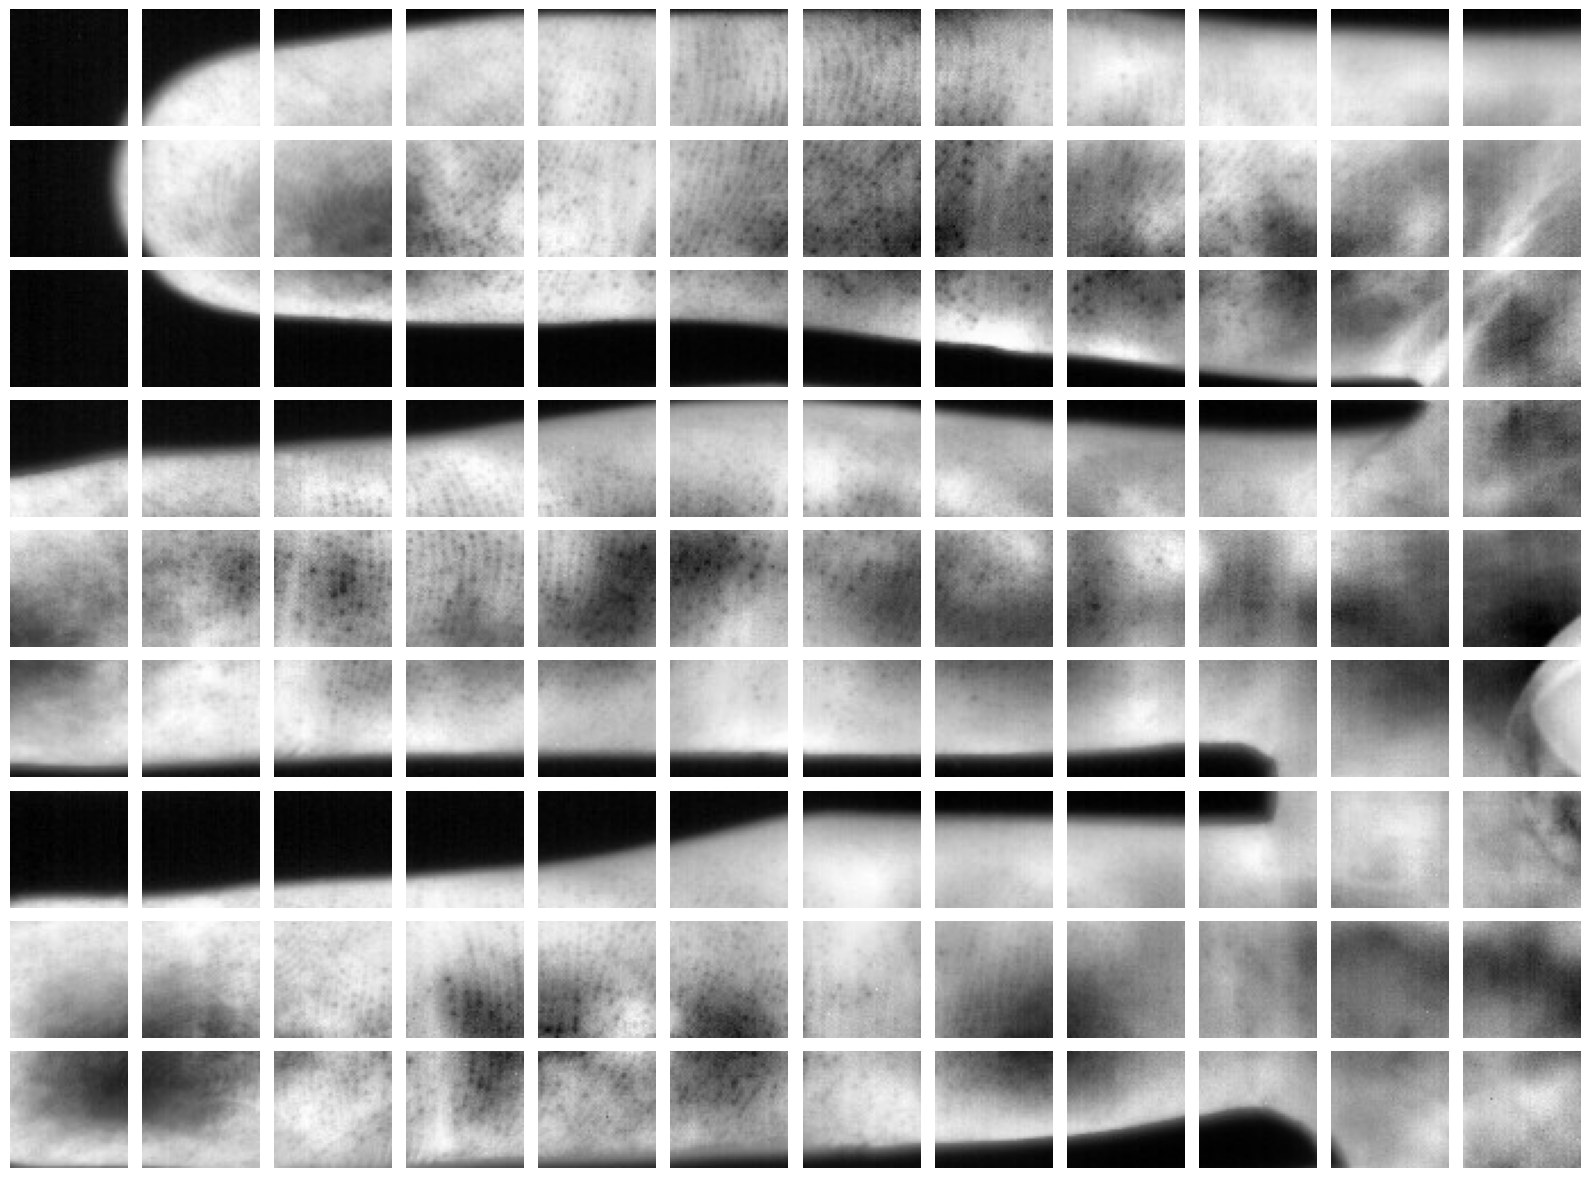

In [17]:
# Get the shape of the image
img_height, img_width, _ = img.shape

# Define the size of each subgrid
subgrid_height = 52
subgrid_width = 52

# Calculate the number of subgrids in each dimension
num_subgrids_height = img_height // subgrid_height
num_subgrids_width = img_width // subgrid_width

print(num_subgrids_height, num_subgrids_width)

# Create a figure and axes for displaying the subgrids
fig, axes = plt.subplots(num_subgrids_height, num_subgrids_width, figsize=(16, 12))
plt.tight_layout()

# Iterate over each subgrid and display it as an image
for i in range(num_subgrids_height):
    for j in range(num_subgrids_width):
        subgrid = img[i*subgrid_height:(i+1)*subgrid_height, j*subgrid_width:(j+1)*subgrid_width, :]
        axes[i, j].imshow(subgrid)
        axes[i, j].axis('off')
        #axes[i, j].set_title(f"Subgrid ({i}, {j})")

# Display the figure with subgrids
plt.tight_layout()
plt.show()

108


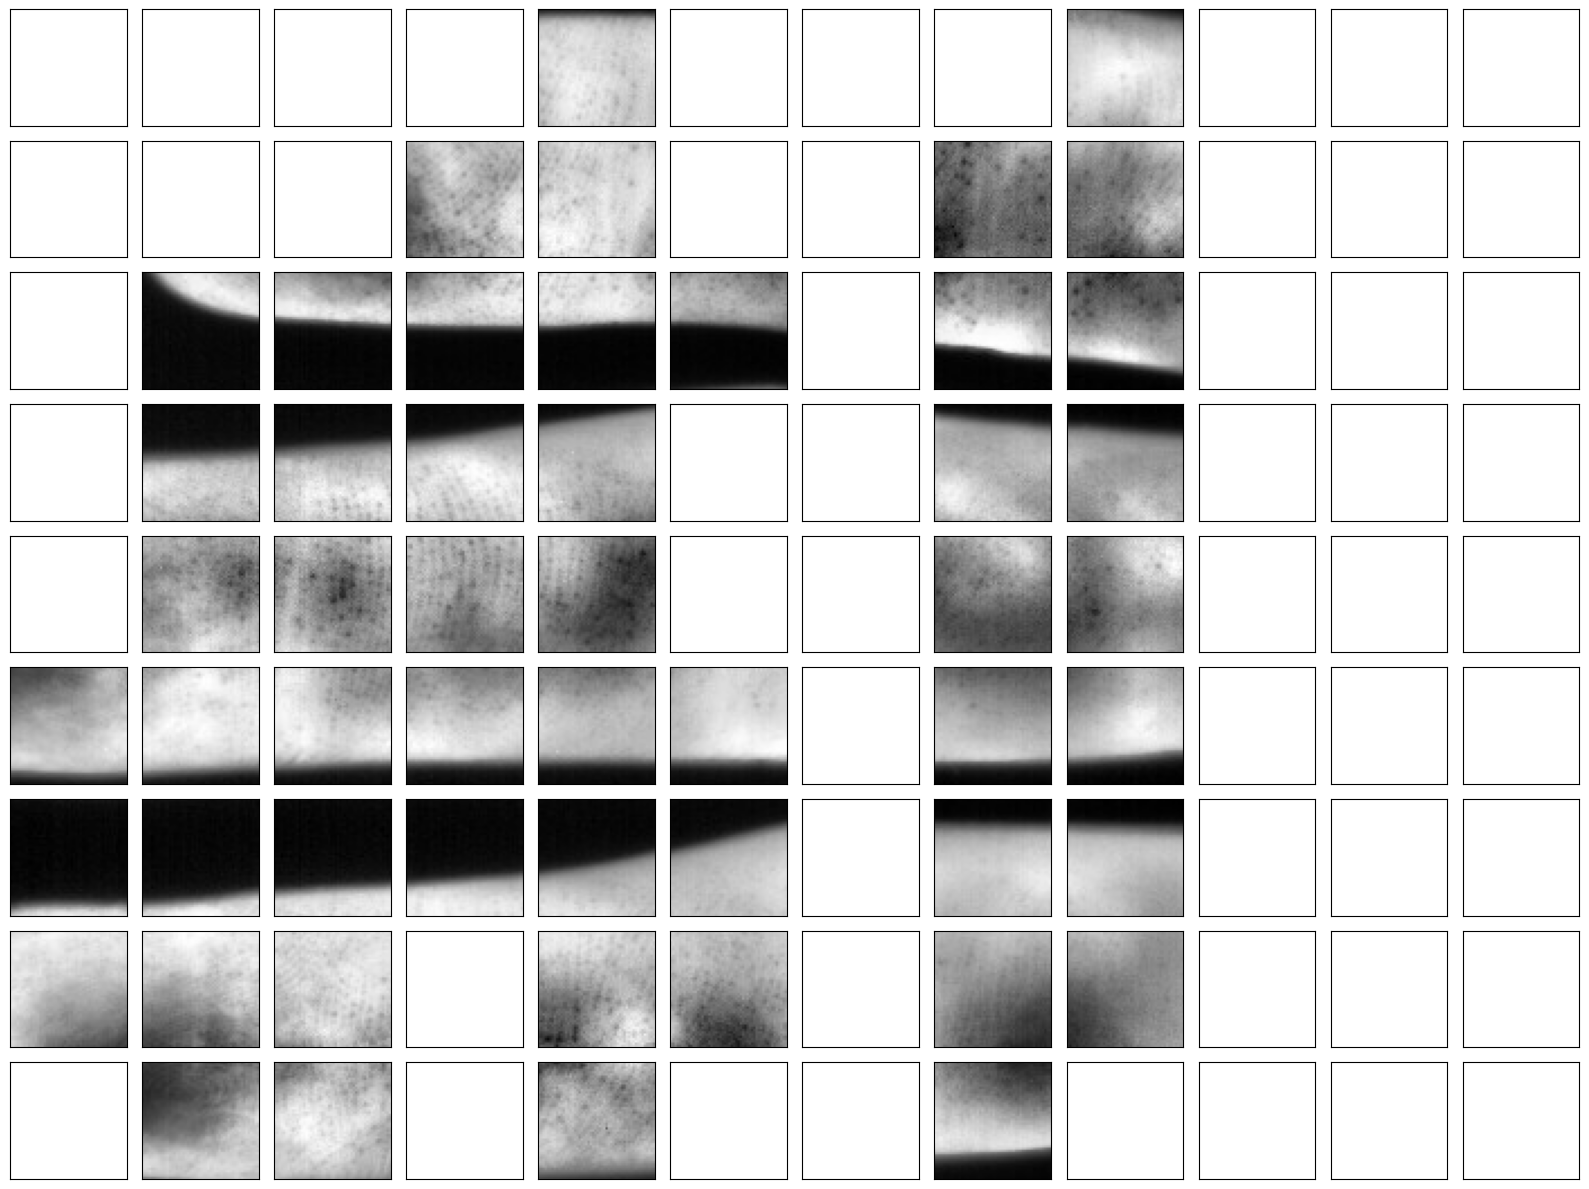

In [26]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import re

# Set up the grid
rows = 9
cols = 12
fig, axes = plt.subplots(rows, cols, figsize=(16, 12))

# Path to your image folder
folder_path = '/Users/rickysu/Projects/sweatPoresActivation/results/valid_batches/17X17'

# Get a list of image files in the folder
image_files = os.listdir(folder_path)

# Function to get order number and label from filename
def get_order_and_label(filename):
    match = re.search(r'_(\d+)_(\d+)', filename)
    if match:
        return int(match.group(1)), int(match.group(2))
    return float('inf'), -1  # Return a large number and invalid label if no match

# Sort the image files based on the order number
image_files.sort(key=lambda x: get_order_and_label(x)[0])

print(len(image_files))

# Create a blank white image
blank_image = np.ones((52, 52, 3), dtype=np.uint8) * 255  # Assuming 17x17 is your image size

# Iterate through the grid
for i in range(rows):
    for j in range(cols):
        index = i * cols + j
        if index < len(image_files):
            # Get the label from the filename
            _, label = get_order_and_label(image_files[index])
            
            if label == 1:
                # Load and display the image with label 1
                img_path = os.path.join(folder_path, image_files[index])
                img = Image.open(img_path)
                img_array = np.array(img)
                axes[i, j].imshow(img_array, cmap='gray' if img_array.ndim == 2 else None)
            else:
                # Display a blank white image for other labels
                axes[i, j].imshow(blank_image, cmap='gray')
        else:
            # Display a blank white image if there are no more images
            axes[i, j].imshow(blank_image, cmap='gray')
        
        # Remove axis 
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

plt.tight_layout()
plt.show()

## **Apply Transformation**
Every thing in Deep Learning is in the form of Tensors. Converting images to tensors is essential for compatibility with deep learning frameworks. Additionally we should also normalized the input images which helps ensure consistency in the input distribution, so that all the tensors are in the same range of [-1, 1]. We can use the method providied by **torchvision.transforms** to do this. 

In [57]:
trans = transforms.Compose([
    transforms.ToTensor(),                                          # Converting img to tensors for the data loader
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # scale the pixel values of the image between -1 and 1
])

In [58]:
train_data = trans(img) # apply transformation
print(train_data.shape)

torch.Size([3, 512, 640])


## **Batching Data and Shuffling**


In [30]:
train_loader = DataLoader(train_data,  batch_size=17, shuffle=True, num_workers=4) 
print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [24]:
batch = next(iter(train_loader))
print(len(batch))

3


In [38]:
batch_images, batch_labels, additional_value = next(iter(train_loader))
batch = next(iter(train_loader))
batch_images = batch[0]
print(batch_images.shape)
batch_labels = batch[1]
print(batch_labels)
additional_value = batch[2]
print(additional_value)

torch.Size([512, 640])
tensor([[-0.9529, -0.9529, -0.9373,  ..., -0.9922, -0.9843, -0.9843],
        [-0.9137, -0.9294, -0.9373,  ..., -0.9608, -0.9608, -0.9608],
        [-0.8902, -0.9059, -0.9294,  ..., -0.9451, -0.9529, -0.9529],
        ...,
        [-0.9608, -0.9529, -0.9373,  ..., -0.4118, -0.3882, -0.5137],
        [-0.9765, -0.9608, -0.9373,  ..., -0.4275, -0.4118, -0.6078],
        [-0.9922, -0.9686, -0.9451,  ..., -0.4980, -0.3882, -0.4824]])
tensor([[-0.9529, -0.9529, -0.9373,  ..., -0.9922, -0.9843, -0.9843],
        [-0.9137, -0.9294, -0.9373,  ..., -0.9608, -0.9608, -0.9608],
        [-0.8902, -0.9059, -0.9294,  ..., -0.9451, -0.9529, -0.9529],
        ...,
        [-0.9608, -0.9529, -0.9373,  ..., -0.4118, -0.3882, -0.5137],
        [-0.9765, -0.9608, -0.9373,  ..., -0.4275, -0.4118, -0.6078],
        [-0.9922, -0.9686, -0.9451,  ..., -0.4980, -0.3882, -0.4824]])


# **Convolutional Neural Networks**